<a href="https://colab.research.google.com/github/michaelgfalk/fugitive-words/blob/master/wow_binary_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction: Version 2 of foreign word detection model

Initial experiments with the more general language modelling approach yielded less than satisfactory results. At best, the model seemed to be able to achieve 50% precision with 75% recall when used to discriminate Aboriginal from English words.

This notebook tries a different approach: what if the problem were seen as a binary classification problem, rather than as a language modelling task.

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Concatenate, LSTM, CuDNNLSTM, Dropout
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.text import Tokenizer # For one-hot encoding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from google.colab import drive # For saving
import pickle as p
import regex as re
import pandas as pd

# Create custom metrics (needed to load/compile model)
def prec(y_true, y_pred):
  t_one = K.greater_equal(y_true, 0.5) # Which words are actually Aboriginal?
  p_one = K.greater_equal(y_pred, 0.5) # Which did the model predict were Aboriginal?
  true_pos = K.all(K.concatenate([t_one, p_one], axis = 1), axis = 1) # Which predictions were correct?
  
  # Cast to float
  true_pos = K.cast(true_pos, 'float16')
  p_one = K.cast(p_one, 'float16')
  
  return K.sum(true_pos) / K.sum(p_one)

def rec(y_true, y_pred):
  t_one = K.greater_equal(y_true, 0.5) # Which words are actually Aboriginal?
  p_one = K.greater_equal(y_pred, 0.5) # Which did the model predict were Aboriginal?
  true_pos = K.all(K.concatenate([t_one, p_one], axis = 1), axis = 1) # Correct predictions of Aboriginal words
  
  # Cast to float
  true_pos = K.cast(true_pos, 'float16')
  t_one = K.cast(t_one, 'float16')
  
  return K.sum(true_pos) / K.sum(t_one)

In [ ]:
# Link to Google drive for disk access
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
# set random seed for notebook
random_seed = 691

# 1. Import and clean training data

For this task, we will use a different training/test set than before. Now we will use both English and Aboriginal words.

In [ ]:
def clean_text(data_frame):
  """Cleans the text of a data_frame, assuming it has a 'word' column."""
  # Drop rows with a comma or space in the word colume
  # This should remove all of the English and phrases that creep into the 'word' column
  filt = ~data_frame.word.str.contains(r',|\s', na = True, regex = True)
  data_frame = data_frame.loc[filt].reset_index(drop = True) # Need to rest index to avoid 'chained assignment' problem
  
  # Peform string operations
  data_frame.loc[:,'word'] = (data_frame['word']
                  .str.replace(r'&.{1,7};', '') # Strip out html entities
                  .str.replace(r'\\N', '') # Strip out missing values written as '\N'
                  .str.replace(r'\(.+\)', '') # Strip out parenthetical comments
                  .str.normalize('NFKD') # Strip out accents
                  .str.encode('ascii', errors='ignore')
                  .str.decode('utf-8') 
                  .str.replace(r'\d|\W|_', '') # Strip out all non-word characters and underscores
                  .str.lower() # To lower case
                 )

  # Only keep rows with three or more characters in the OriginalForm
  data_frame = data_frame.loc[data_frame.word.str.len() >= 3].reset_index(drop = True)
  
  return data_frame

## 1.1 Import Aboriginal Corpora

In [ ]:
# Import chirila csv
with open('/content/gdrive/My Drive/waves_of_words/chirila_data.csv') as f:
  chirila_df = pd.read_csv(f)
  
chirila_df.columns = ['id', 'lang', 'word', 'row_number']

print(f'There are {len(chirila_df)} words in the chirila dataset.')

There are 229090 words in the chirila dataset.


In [ ]:
# First filter out the silly results:

# Drop rows with an NaN
chirila_df.dropna(thresh = 3, inplace = True)

chirila_df = clean_text(chirila_df)

# Sanity check
print(f'After preprocessing, there are {len(chirila_df)} training examples in chirila_df.')

After preprocessing, there are 191091 training examples in chirila_df.


## 1.2 Import English corpora

In [ ]:
# Get training data from NLTK
import nltk
nltk.download('brown')
nltk.download('reuters')
nltk.download('gutenberg')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.


True

In [ ]:
# Get training data from BYU corpora samples
byu_words = []
with open('/content/gdrive/My Drive/waves_of_words/byu_lexicons.txt', 'r') as file:
  for line in file:
    line = line.rstrip() # remove trailing whitespace
    byu_words.append(line) 

# Sanity check:
print(f'There are {len(byu_words)} unique types in the byu corpora. The first five are:\n {byu_words[0:4]}')

There are 114097 unique types in the byu corpora. The first five are:
 ['word', 'the', 'and', 'of']


In [ ]:
# Combine into single wordlist
words = set(nltk.corpus.brown.words() + nltk.corpus.reuters.words() + nltk.corpus.gutenberg.words() + byu_words)
words = list(words)

In [ ]:
# If you need it, write the English words to a .txt file

#with open('/content/gdrive/My Drive/waves_of_words/english_list.txt', 'wt') as file:
#  for word in words:
#    file.write('%s\n' % word)

In [ ]:
# Put into compatible DataFrame
english_data = pd.DataFrame({'lang':['english' for _ in words], 'word':words}, columns = ['lang','word'])

# Apply the same preprocessing routine:
english_data = clean_text(english_data)

# Sanity check
print(f'After preprocessing, there are {len(english_data)} training examples in english_data.')

After preprocessing, there are 181375 training examples in english_data.


## 1.3 Combine corpora and tokenise

In [ ]:
# Concatenate the data frames
data = pd.concat([chirila_df[['lang','word']], english_data], ignore_index = True)

# Add a y column
data['y'] = (data.lang != 'english').astype('float') # 1 = Indigenous word, 0 = English

# Sanitiy check
print(f'There are {len(chirila_df)} rows in `chirila_df` and {len(english_data)} in `english_data`.')
print(f'There are {data.y.sum().astype(np.int32)} Aboriginal words and {(1 - data.y.values).sum().astype(np.int32)} English words in `data`.')
print(f'The number of rows in `data` is {len(data)}')

# Add start and end characters
data['word'] = data['word'].apply(lambda x: 'S' + x + 'E')

print('Ten random rows from `data`:')
data.sample(10)

There are 191091 rows in `chirila_df` and 181375 in `english_data`.
There are 191091 Aboriginal words and 181375 English words in `data`.
The number of rows in `data` is 372466
Ten random rows from `data`:


,lang,word,y
225492,english,SleanjawedE,0.0
212029,english,SemmalineE,0.0
315902,english,SyeeE,0.0
199279,english,SmajkerzieE,0.0
369963,english,SskycarvingE,0.0
98242,Narungga,SngaruE,1.0
367965,english,ScastillaE,0.0
208438,english,SlookedE,0.0
284414,english,SfoodE,0.0
94748,Mithaka,SkirkindariE,1.0


In [ ]:
# Format for tensorflow
tkzr = Tokenizer(lower = False, char_level = True, oov_token = "?", filters = None) # out-of-vocab character represented by ?
tkzr.fit_on_texts(data['word'])
seq_list = tkzr.texts_to_sequences(data['word'])
X = pad_sequences(seq_list, padding = 'pre', truncating = 'pre', maxlen = 20) # Cap the length of the sequnces at 20 characters

In [ ]:
# Save data for later use
with open('/content/gdrive/My Drive/waves_of_words/20190306_binary_model_data_and_tkzr.p', 'wb') as f:
  p.dump((data, tkzr), f)

In [ ]:
# If revisiting this notebook, import the data:
with open('/content/gdrive/My Drive/waves_of_words/20190306_binary_model_data_and_tkzr.p', 'rb') as f:
  data, tkzr = p.load(f)

In [ ]:
# Get dimensions
# Convert data to one-hot encoding

# Make sure that you're working with the right X
assert len(X.shape) == 2

print(f'Data dimensions before one-hot-encoding: {X.shape}')
X = tf.keras.utils.to_categorical(X, dtype = 'float32') # For some reason Tensorflow requires a float input
print(f'Data dimensions after one-hot-encoding: {X.shape}')
X = X[:,:,1:] # Drop padding (we don't want the LSTM to learn a feature for an empty timestep)
print(f'Data dimensions after dropping padding feature: {X.shape}')
m, t, n = X.shape

# Shuffle and split
X_train, X_test, y_train, y_test = train_test_split(X, data['y'], test_size = 0.1, random_state = random_seed, stratify = data['y'])

# Sanity check
print(f'The shape of X_train is {X_train.shape}')
print(f'The shape of X_test is {X_test.shape}')
print(f'The shape of y_train is {y_train.shape}')
print(f'The shape of y_test is {y_test.shape}')

Data dimensions before one-hot-encoding: (372466, 20)
Data dimensions after one-hot-encoding: (372466, 20, 30)
Data dimensions after dropping padding feature: (372466, 20, 29)
The shape of X_train is (335219, 20, 29)
The shape of X_test is (37247, 20, 29)
The shape of y_train is (335219,)
The shape of y_test is (37247,)


# 2. Instantiate and train model

In [ ]:
def init_lstm(max_time, num_features, hidden_state_dim = 10, rnn_layers = 3, drop_rate = 0.5):
  """
  Deep bidirectional LSTM for binary classification problem.
  
  params:
    max_time (int): the maximum sequence length in the training data
    num_features (int): the number of individual characters in the training set
    lstm_hidden (int): the size of the hidden state in the LSTM cells
    num_rnn_layers (int): the number of LSTM layers desired
    drop_rate (float: 0 < x =< 1): the number of inputs to randomly ignore in the Dropout layers
  
  returns:
    lstm_net: a Keras Model() object
  """
  
  # Define input to model
  # NB: Althought an integer input might seem to make sense for one-hot encoding, tf requires a float input
  seq_in = Input(shape = (max_time, num_features), dtype = 'float32', name = "seq_in")
  
  # Hidden forward layers
  for i in range(rnn_layers):
    if i == 0: # first layer
      X_forw = CuDNNLSTM(units = hidden_state_dim, return_sequences = True, name = "lstm_forward_" + str(i))(seq_in)
    elif i == (rnn_layers - 1): # final layer
      X_forw = CuDNNLSTM(units = hidden_state_dim, return_sequences = False, name = "lstm_forward_" + str(i))(X_forw)
    else: # all the others
      X_forw = CuDNNLSTM(units = hidden_state_dim, return_sequences = True, name = "lstm_forward_" + str(i))(X_forw)
    X_forw = Dropout(rate = drop_rate, name = "dropout_forward_" + str(i))(X_forw)
  
  # Hidden backward layers
  for i in range(rnn_layers):
    if i == 0: # first layer
      X_back = CuDNNLSTM(units = hidden_state_dim, return_sequences = True, go_backwards = True, name = "lstm_backward_" + str(i))(seq_in)
    elif i == (rnn_layers - 1): # final layer
      X_back = CuDNNLSTM(units = hidden_state_dim, return_sequences = False, go_backwards = True, name = "lstm_backward_" + str(i))(X_back)
    else: # all the others
      X_back = CuDNNLSTM(units = hidden_state_dim, return_sequences = True, go_backwards = True, name = "lstm_backward_" + str(i))(X_back)
    X_back = Dropout(rate = drop_rate, name = "dropout_backward_" + str(i))(X_back)

  # Concatenate the hidden states
  X = Concatenate()([X_forw, X_back])
  
  # Activation layer (apply once to each word)
  Yhat = Dense(1, activation = "sigmoid")(X)
  
  # Create model
  lstm_net = Model(inputs = [seq_in], outputs = Yhat)
  
  return lstm_net

In [ ]:
# Set hyperparameters
hd = 100
l = 4
dr = 0.3

# Initialise model
model = init_lstm(max_time = t, num_features = n, hidden_state_dim = hd, rnn_layers = l, drop_rate = dr)

# Sanity check
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_in (InputLayer)             (None, 20, 29)       0                                            
__________________________________________________________________________________________________
lstm_forward_0 (CuDNNLSTM)      (None, 20, 100)      52400       seq_in[0][0]                     
__________________________________________________________________________________________________
lstm_backward_0 (CuDNNLSTM)     (None, 20, 100)      52400       seq_in[0][0]                     
__________________________________________________________________________________________________
dropout_forward_0 (Dr

In [ ]:
# Create optimizer and compile
opt = tf.keras.optimizers.Adam(clipnorm = 5)
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = [prec,rec])

In [ ]:
# Train new model using class weights and save
hist = model.fit(x = X_train, y = y_train,
          batch_size = 512, epochs = 28,
          validation_data = [X_test, y_test],
          verbose = 2)


model.save('/content/gdrive/My Drive/waves_of_words/20190307_binary_model_30_epochs.h5')

Train on 335219 samples, validate on 37247 samples
Epoch 1/28
 - 66s - loss: 0.1538 - prec: 0.9337 - rec: 0.9459 - val_loss: 0.1496 - val_prec: 0.9296 - val_rec: 0.9544
Epoch 2/28
 - 65s - loss: 0.1461 - prec: 0.9373 - rec: 0.9490 - val_loss: 0.1454 - val_prec: 0.9426 - val_rec: 0.9425
Epoch 3/28
 - 66s - loss: 0.1404 - prec: 0.9405 - rec: 0.9513 - val_loss: 0.1395 - val_prec: 0.9464 - val_rec: 0.9413
Epoch 4/28
 - 66s - loss: 0.1360 - prec: 0.9423 - rec: 0.9531 - val_loss: 0.1382 - val_prec: 0.9334 - val_rec: 0.9597
Epoch 5/28
 - 66s - loss: 0.1327 - prec: 0.9434 - rec: 0.9542 - val_loss: 0.1337 - val_prec: 0.9348 - val_rec: 0.9616
Epoch 6/28
 - 66s - loss: 0.1296 - prec: 0.9452 - rec: 0.9557 - val_loss: 0.1324 - val_prec: 0.9411 - val_rec: 0.9560
Epoch 7/28
 - 65s - loss: 0.1265 - prec: 0.9464 - rec: 0.9568 - val_loss: 0.1327 - val_prec: 0.9519 - val_rec: 0.9453
Epoch 8/28
 - 65s - loss: 0.1238 - prec: 0.9480 - rec: 0.9576 - val_loss: 0.1283 - val_prec: 0.9412 - val_rec: 0.9608
Epoch

# 3. Evaluate the model

Have a look at how it's going on the training and test data.

In [ ]:
from matplotlib import pyplot as plt
plt.style.use('dark_background')
%matplotlib inline

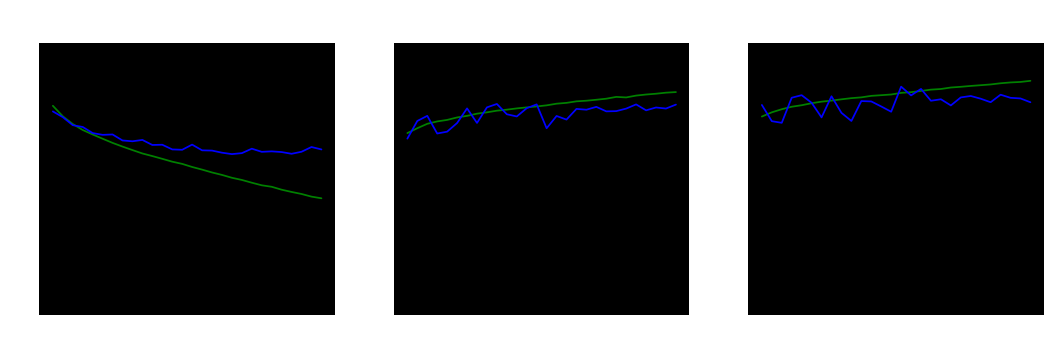

In [ ]:
epochs = [x + 3 for x,y in enumerate(hist.history['loss'])] # generate sequences of x-values
f, (lplt, pplt, rplt) = plt.subplots(1, 3, figsize = (18,5), sharex = True)

lplt.plot(epochs, hist.history['loss'], color = 'g')
lplt.plot(epochs, hist.history['val_loss'], color = 'b')
lplt.set_ylim([0., 0.2])

pplt.plot(epochs, hist.history['prec'], color = 'g')
pplt.plot(epochs, hist.history['val_prec'], color = 'b')
pplt.set_ylim([0.8, 1.])

rplt.plot(epochs, hist.history['rec'], color = 'g')
rplt.plot(epochs, hist.history['val_rec'], color = 'b')
rplt.set_ylim([0.8, 1.])

f.suptitle('Loss, Precision and Recall on the Training and Test sets (30 epochs)')

plt.show()

# 4. Try on some Trove data

Now we've trained the model, how terribly does it do on actual Trove data?

In [ ]:
# Load sample articles
with open('/content/gdrive/My Drive/waves_of_words/one_thousand_articles.p', 'rb') as file:
  one_thousand_articles = p.load(file)

# Load tokeniser (no need to load the data)
with open('/content/gdrive/My Drive/waves_of_words/20190306_binary_model_data_and_tkzr.p', 'rb') as f:
  _, tkzr = p.load(f)

# Load the model
model = load_model('/content/gdrive/My Drive/waves_of_words/20190307_binary_model_30_epochs.h5', custom_objects = {'prec':prec, 'rec':rec})

In [ ]:
# Preprocess text:
samp_df = pd.DataFrame(data = one_thousand_articles, columns = ['id', 'art_id', 'tokens'])

# Unnest the list column
unnested = samp_df.set_index(['id', 'art_id'])['tokens'].apply(pd.Series).stack().reset_index()
unnested.columns = ['id', 'art_id', 'tkn_idx', 'token']

# Drop duplicates
unnested.drop_duplicates(subset = 'token', inplace = True)

# Preprocess tokens
unnested.loc[:,'token'] = (unnested['token']
                  .str.replace(r'&.{1,7};', '') # Strip out html entities
                  .str.replace(r'\\N', '') # Strip out missing values written as '\N'
                  .str.replace(r'\(.+\)', '') # Strip out parenthetical comments
                  .str.normalize('NFKD') # Strip out accents
                  .str.encode('ascii', errors='ignore')
                  .str.decode('utf-8') 
                  .str.replace(r'\d|\W|_', '') # Strip out all non-word characters and underscores
                  .str.lower() # To lower case
                 )

# Add start and end symbols
unnested['token'] = unnested['token'].apply(lambda x: 'S' + x + 'E')

# Apply tokensier
seq_list = tkzr.texts_to_sequences(unnested['token'])
maxlen = 20
X = pad_sequences(seq_list, padding = 'pre', truncating = 'pre', maxlen = maxlen)

# One-hot encode
X = tf.keras.utils.to_categorical(X, dtype = 'float32')

# Remove padding slice
X = X[:,:,1:]

# Sanity check
print(f'There are {len(unnested)} tokens in the `unnested` data frame.')
print(f'Sequences are capped at {maxlen} characters.')
print(f'There are {len(tkzr.word_index)} characters in the tokenizer\'s vocabulary')
print(f'`X` has dimensions {X.shape[0]}, {X.shape[1]} and {X.shape[2]}.')

There are 106409 tokens in the `unnested` data frame.
Sequences are capped at 20 characters.
There are 29 characters in the tokenizer's vocabulary
`X` has dimensions 106409, 20 and 29.


In [ ]:
# Predict which of the tokens are aboriginal words.
unnested['y_hat'] = model.predict(X) # Get probabilities
unnested['class'] = unnested.y_hat >= 0.5 # Classify

In [ ]:
# Which articles have the greatest number of 'aboriginal' words?
aboriginal_words_per_article = (unnested[['art_id','class']]
                                .groupby('art_id') # consider each article
                                .sum() # Sum the number of aboriginal words (english = 0)
                                .reset_index()
                                .sort_values('class', ascending = False)
                               )
aboriginal_words_per_article['url'] = (aboriginal_words_per_article['art_id']
                                       .apply(lambda x: "https://trove.nla.gov.au/newspaper/article/" + str(x)))

In [ ]:
# Have a look at some of them
from functools import partial

def inspect_general(idx, df_one, df_two):
  # Print the url
  print(df_one['url'].iloc[idx])
  
  # Get data for particular article
  article = df_one['art_id'].iloc[idx]
  article_data = df_two[df_two['art_id'] == article]
  
  # List the predicted aboriginal words
  ab_wrds = article_data[article_data['class'] == True]
  print(f'Of {len(article_data)} examined words, {len(ab_wrds)} were found to be aboriginal.')
  print(f'Supposed aboriginal words:')
  display(ab_wrds.sort_values('y_hat', ascending = False))
  
  return None
  
inspect_article = partial(inspect_general, df_one = aboriginal_words_per_article, df_two = unnested)

In [ ]:
# Another way of filtering the results: which articles have the highest proportion of words with
# scores over a certain threshold?
def compute_prop(df, threshold = 0.8):
  
  num_over = len(df[df['y_hat'] > threshold])
  num_rows = len(df)
  
  prop = num_over / num_rows
  
  out = pd.DataFrame.from_dict({'prop' : [prop], 'words_examined' : [num_rows]})
  
  return out

highest_prop = (unnested[['art_id','y_hat']]
                .groupby('art_id') # consider each article
                .apply(compute_prop) # Get the proportion
                .sort_values('prop', ascending = False)
                .reset_index()
               )
highest_prop['url'] = highest_prop['art_id'].apply(lambda x: "https://trove.nla.gov.au/newspaper/article/" + str(x))

In [ ]:
def inspect_two(idx, df_one, df_two):
  
  # Print the url
  print(df_one['url'].iloc[idx])
  
  # Get data for particular article
  article = df_one['art_id'].iloc[idx]
  article_data = df_two[df_two['art_id'] == article]
  
  # List the predicted aboriginal words
  ab_wrds = article_data[article_data['y_hat'] > 0.8]
  print(f'Of {len(article_data)} examined words, {len(ab_wrds)} had a greater probability than 0.8.')
  print(f'Supposed aboriginal words:')
  display(ab_wrds.sort_values('y_hat', ascending = False))
  
  return None

In [ ]:
highest_prop_fil = highest_prop[highest_prop['words_examined'] > 100]
insp_prop_dat = partial(inspect_two, df_one = highest_prop_fil, df_two = unnested)

In [ ]:
insp_prop_dat(6)

https://trove.nla.gov.au/newspaper/article/18587021
Of 267 examined words, 40 had a greater probability than 0.8.
Supposed aboriginal words:


,id,art_id,tkn_idx,token,y_hat,class
49812,347860,18587021,261,SooaatrucE,0.999987,True
49666,347860,18587021,115,SpupuliE,0.999940,True
49704,347860,18587021,153,SltiljijE,0.998638,True
49675,347860,18587021,124,StharuE,0.998021,True
49711,347860,18587021,160,SkiiiwayE,0.996767,True
49741,347860,18587021,190,SpoaaliE,0.992320,True
49756,347860,18587021,205,SuuvernmrctE,0.990817,True
49594,347860,18587021,43,SuiembenE,0.986694,True
49692,347860,18587021,141,SnuiketaE,0.983120,True
49730,347860,18587021,179,SlaruE,0.979458,True


After a first look at the results, a few thoughts:

- The model definitely struggles with messy OCR. Exposing it to messy OCR would be one solution. Cleaning up the training data somehow would be another.
- If you look simply for articles that have the most positives you get a lot of advertisments. Advertisements can probably simply be excluded from the search, using the 'category' column in the WoW database.
- There are a lot of place names. Perhaps known place names could be added to the stopwords list, by harvesting them from geonames, for example?
- Lots of the articles contain duplicate aboriginal words, e.g. a short story whose characters have aboriginal names, or a news story that refers repeatedly to the same place. So it is a good idea to keep only unique tokens for each article before running the model.